In [33]:
# Required imports
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster

In [34]:
# Load dataset
data = pd.read_csv("palay_quarterly.csv")

# Convert Year and Quarter into a datetime format
data['date'] = pd.to_datetime(data['Year'].astype(str) + 'Q' + data['Quarter'].astype(str))
data.set_index('date', inplace=True)
data = data[['Palay']]  # Keep only the 'Palay' column

# Create dummy exogenous variables (Temperature and Rainfall)
np.random.seed(123)
data['Temperature'] = np.random.normal(30, 5, size=len(data))  # Simulating temperature data
data['Rainfall'] = np.random.normal(100, 20, size=len(data))   # Simulating rainfall data
# Verify that the data includes the exogenous variables
print(data.head())

            Palay  Temperature    Rainfall
date                                      
1987-01-01  12340    24.571847   85.295661
1987-04-01   3050    34.986727  110.024980
1987-07-01   5569    31.414892  120.254781
1987-10-01  10485    22.468526  105.574817
1988-01-01   6644    27.106999   72.581031


C:\Users\harol\AppData\Local\Temp\ipykernel_21564\2613461009.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['Year'].astype(str) + 'Q' + data['Quarter'].astype(str))


In [35]:
# Ensure DatetimeIndex has a proper frequency (quarterly in this case)
# ==============================================================================
data = data.asfreq('QS-JAN')


In [36]:
# Split data into train and test sets
# ==============================================================================
steps = 8  # Predicting for 4 years (16 quarters)
data_train = data[:-steps]
data_test  = data[-steps:]

# Exogenous variables for training and testing
# ==============================================================================
exog_train = data_train[['Temperature', 'Rainfall']].asfreq('QS-JAN')
exog_test = data_test[['Temperature', 'Rainfall']].asfreq('QS-JAN')


In [37]:
# Display training and testing information
# ==============================================================================
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")



Train dates : 1987-01-01 00:00:00 --- 2012-10-01 00:00:00  (n=104)
Test dates  : 2013-01-01 00:00:00 --- 2014-10-01 00:00:00  (n=8)


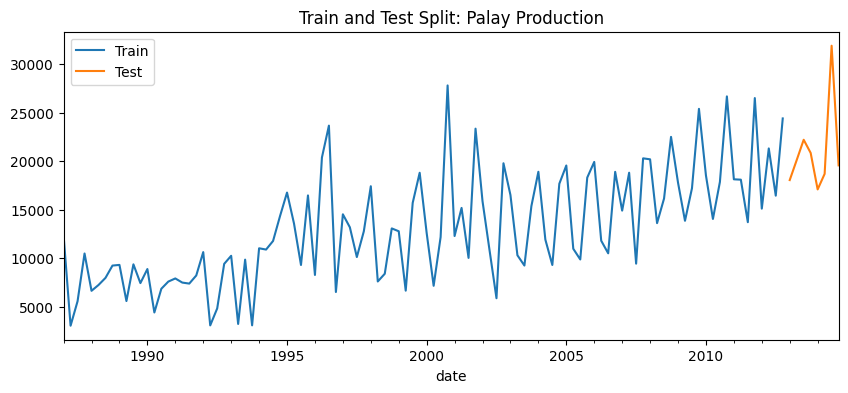

In [38]:
# Plot the train and test sets
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 4))
data_train['Palay'].plot(ax=ax, label='Train')
data_test['Palay'].plot(ax=ax, label='Test')
ax.legend()
plt.title('Train and Test Split: Palay Production')
plt.show()


In [39]:
# Create and train the forecaster with exogenous variables
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123),
    lags=6  # You can tune this value
)


In [42]:
# Hyperparameter tuning with grid search
# ==============================================================================

# Define the hyperparameter grid for tuning both lags and regressor parameters
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],  # Removed 'auto'
}

# Candidate values for lags
lags_grid = [6, 12, 18, 24, 30, 36]

# Grid search over hyperparameters and lags
# ==============================================================================
results_grid = grid_search_forecaster(
    forecaster         = forecaster,
    y                  = data_train['Palay'],
    exog               = exog_train,
    param_grid         = param_grid,
    lags_grid          = lags_grid,
    steps              = steps,
    metric             = 'mean_squared_error',
    initial_train_size = int(len(data_train)*0.8),
    fixed_train_size   = False,
    refit              = True,  # Refit the model with the best parameters
    return_best        = True,
    verbose            = False,
    n_jobs             = 'auto'
)

# Display results from grid search
# ==============================================================================
print(f"Number of models compared: {len(results_grid)}")
print("Best parameters found:")
print(results_grid)


Number of models compared: 2592.


lags grid: 100%|██████████| 6/6 [31:43<00:00, 317.24s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
  Backtesting metric: 15760171.395752983

Number of models compared: 2592
Best parameters found:
                                                   lags   
1152  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  \
1260  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
828             [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]   
1153  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
829             [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]   
...                                                 ...   
2590  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2264  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2262  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2258  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,

In [43]:
# Train the final model with the best parameters and lags found
# ==============================================================================
best_params = results_grid.iloc[0]['params']
best_lags = results_grid.iloc[0]['lags']
print(f"Best hyperparameters: {best_params}, Best lags: {best_lags}")

forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(**best_params),
    lags      = best_lags
)

# Fit the final model
forecaster.fit(y=data_train['Palay'], exog=exog_train)

Best hyperparameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, Best lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


In [44]:
# Make predictions using the exogenous variables for the test period
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=exog_test)


In [45]:
# Assign the correct DatetimeIndex from the test set to the predictions
# ==============================================================================
predictions = pd.Series(predictions, index=data_test.index)

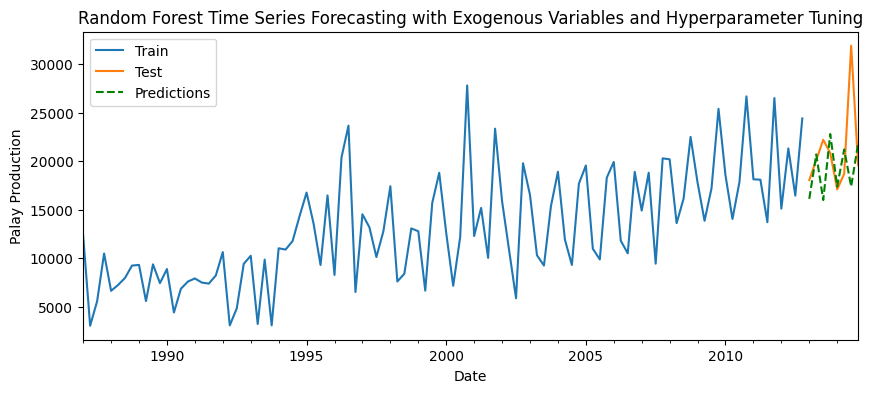

In [46]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 4))
data_train['Palay'].plot(ax=ax, label='Train')
data_test['Palay'].plot(ax=ax, label='Test')
predictions.plot(ax=ax, label='Predictions', linestyle='--', color='green')
ax.legend()
plt.title("Random Forest Time Series Forecasting with Exogenous Variables and Hyperparameter Tuning")
plt.ylabel("Palay Production")
plt.xlabel("Date")
plt.show()

In [47]:
# Calculate performance metrics
# ==============================================================================
mse = mean_squared_error(data_test['Palay'], predictions)
mae = mean_absolute_error(data_test['Palay'], predictions)
r2 = r2_score(data_test['Palay'], predictions)

# Print results
# ==============================================================================
print(f"Test error (MSE): {mse}")
print(f"Test error (MAE): {mae}")
print(f"Test R-squared (R²): {r2}")

Test error (MSE): 33518622.925696738
Test error (MAE): 3781.657481060606
Test R-squared (R²): -0.7634362011128379
